# 02. 데이터 탐색

In [5]:
library(tidyverse)
library(tidymodels)
ggplot2::theme_set(theme_bw())
tidymodels_prefer()
library(modeldata)

- Ames 주택 데이터 세트 ( De Cock 2011 )

In [4]:
data(ames)
ames %>% dim

[1] 2930   74

<br>

## 02.01. 탐색

#### 히스토그램
- **데이터가 오른쪽으로 치우쳐 있음 $\rightarrow$ 모델링시 로그 변환 필요**
- 비싼 집보다 싼 집이 더 많으며, 평균 판매 가격은 \\$160,000였으며, 가장 비싼 주택은 \\$755,000

In [8]:
ames$Sale_Price %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12789  129500  160000  180796  213500  755000 

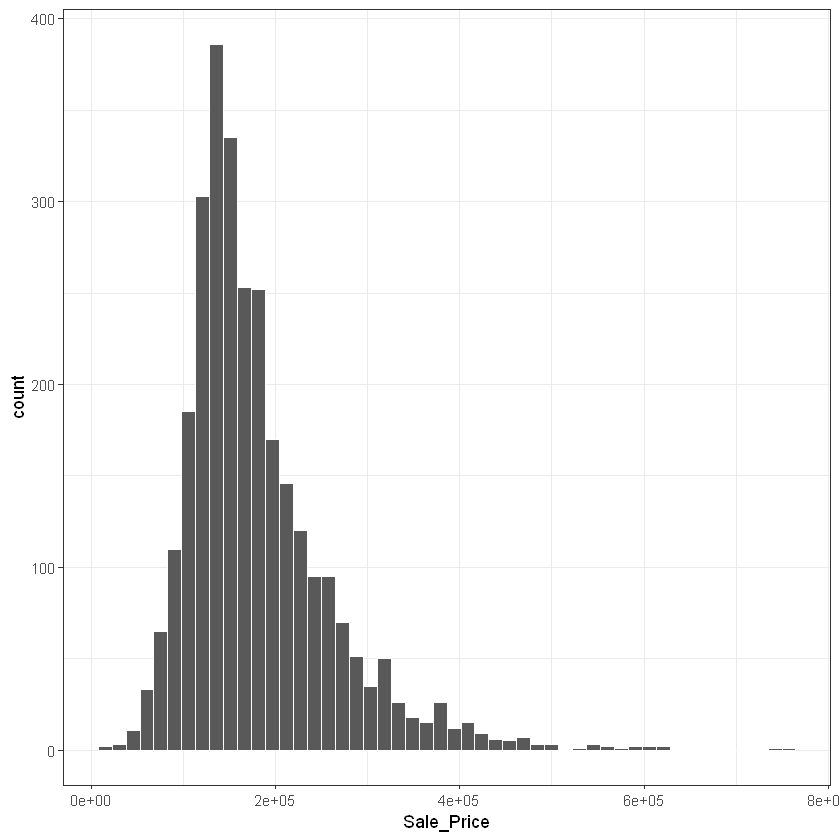

In [6]:
ggplot(ames, aes(Sale_Price)) + 
    geom_histogram(bins = 50, col = "white")

<br>

#### 로그 변환 히스토그램
- **로그 변환의 단점은 해석과 성능 측정에 어려움을 줄 수 있음**
    - RMSE(평균 제곱근 오차)는 회귀 모델에 사용되는 일반적인 성능 지표이며, 계산 시 관찰된 값과 예측된 값의 차이를 사용
    - 판매 가격이 로그 변환된 경우 오차(즉, 잔차)도 로그 변환이 적용 됨
        
        이러한 로그 변환에서 RMSE가 0.15인 모델의 품질을 이해하기 어려울 수 있음

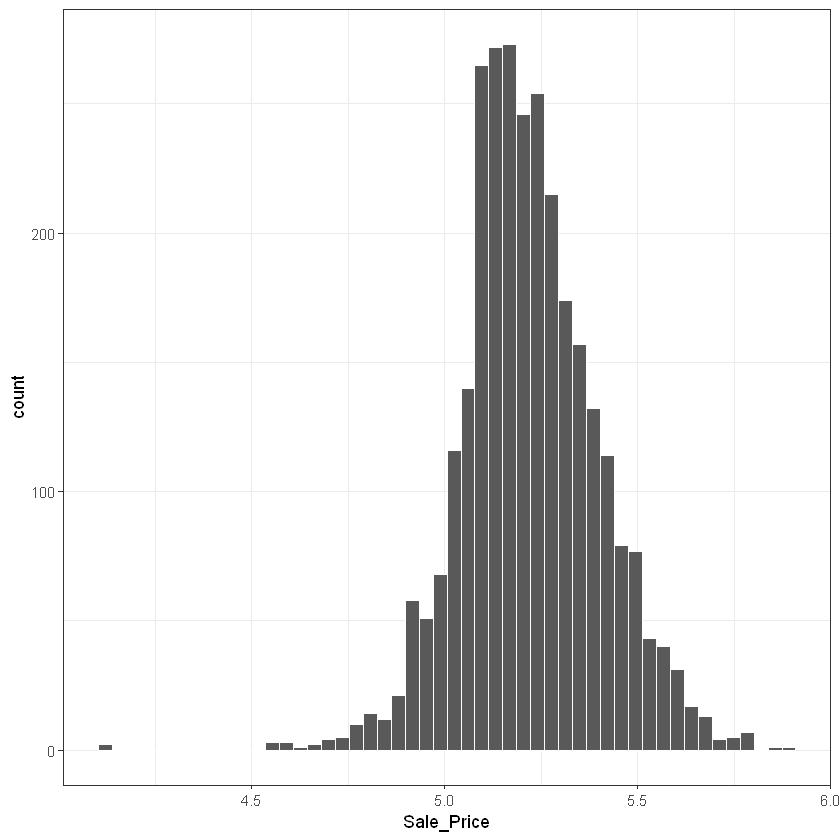

In [9]:
ames <- ames %>% mutate(Sale_Price = log10(Sale_Price))
ggplot(ames, aes(Sale_Price)) + 
    geom_histogram(bins = 50, col = "white")

<br>

## 02.02. 데이터 정제
- 매개변수 추정, 모델 선택 및 조정, 성능 평가를 포함하여 유용한 모델을 생성하는 여러 단계가 존재
- 일반적으로 이러한 모든 작업에 사용할 수 있는 초기 데이터 풀이 유한하며, 이를 사용 가능한 데이터 예산이라고 간주 할 시, 
    
    데이터 소비에 대한 아이디어는 모델링 시, 특히 경험적 검증과 관련하여 중요한 첫 번째 고려 사항
    
<br>

- **데이터가 유한한 데이터 예산에서 신중하게 "사용"되는 대신, 여러 작업에 재사용되면 방법론적 오류로 인한 편향이 강조되거나 복합적인 효과가 발생할 위험과 같은 특정 위험이 증가**
- 사용 가능한 데이터의 양이 많을 때, 현명한 전략은 모델 매개변수 추정에만 가능한 최대량(또는 전부)을 할당하는 대신, 

    다양한 작업에 특정 데이터 하위 집합을 할당
    - 가능한 전략 중 하나(데이터와 변수가 모두 풍부한 경우)는 특정 데이터 하위 집합을 사용하여 어떤 변수가 유익한지 결정
    - 사용 가능한 초기 데이터 풀이 크지 않은 경우, 데이터가 "사용"되거나 할당되는 방법과 시기가 일부 중복될 수 있으므로 데이터 지출에 대한 견고한 방법론이 중요

<br>

## 02.03. 데이터 분할
- 경험적 모델 검증을 위한 기본 접근 방식은 기존 데이터 풀을 훈련 세트와 테스트 세트의 두 가지 개별 세트로 분할
    - 데이터의 일부는 모델을 개발하고 최적화하는 데 사용
    - 훈련 세트는 일반적으로 데이터의 대부분을 차지하며, 다양한 모델을 적용하고 기능 엔지니어링 전략을 조사하는 등의 모델 구축을 위한 샌드박스

<br>

- 데이터의 다른 부분은 테스트 세트
    - 테스트 세트는 모델의 효율성을 결정하기 위한 최종 중재자로 사용
    - **테스트 세트는 한 번만 사용되 것이 중요합니다. 그렇지 않으면 모델링 프로세스의 일부가 됨**

<br>


#### 데이터 분할
- 데이터의 80%를 훈련 세트에 할당하고 나머지 20%를 테스트에 할당

#### ```rsample::initial_split(prop)```
- `prop` : 계층화 샘플링에 적용할 컬럼

<br>

#### ```rsample::initial_time_split()```

In [33]:
set.seed(501)
ames_split <- initial_split(ames, prop = 0.8)

- `rsplit` 개체는 분할 정보만 포함

In [34]:
ames_split

<Training/Testing/Total>
<2344/586/2930>

- 데이터 분할

In [35]:
ames_train <- training(ames_split)
ames_test <- testing(ames_split)
ames_train %>% dim ; ames_test %>% dim

[1] 2344   74

[1] 586  74

<br>

- 단순 무작위 샘플링은 많은 경우에 적합하지만, **분류 문제에 클래스 불균형이 있는 경우문제 발생 가능**
    -  단순 무작위 샘플을 사용하면 훈련 또는 테스트 세트에 불균형하게 할당할 수 있음
    
    $\rightarrow$ 계층화 샘플링
    
    - 훈련/테스트 분할은 각 클래스 내에서 별도로 수행된 다음 이러한 하위 샘플이 전체 훈련 및 테스트 세트로 결합
    - 회귀 문제의 경우 결과 데이터를 인위적으로 사분위수로 분류한 다음 계층화 샘플링을 4회 개별적으로 수행
    
    (이는 학습 세트와 테스트 세트 간에 결과 분포를 유사하게 유지하는 효과적인 방법)
    

<br>

- 훈련 세트에 데이터가 너무 적으면 모델이 적절한 매개변수 추정치를 찾는 능력이 저하
- 반대로 테스트 세트에 데이터가 너무 적으면 성능 추정의 품질이 저하

<br>

### 계층화 샘플링
<br>

- 계층화된 샘플링은 단점이 거의 없음
- 시계열 데이터의 경우, 특정 시간을 기준으로 훈련/테스트 데이터 분할

In [40]:
sale_dens <- density(ames$Sale_Price, n = 2^10) %>% tidy() 

In [41]:
quantiles <- quantile(ames$Sale_Price, probs = c(1:3) / 4)
quantiles <- tibble(prob = (1:3 / 4), value = unname(quantiles))
quantiles$y <- approx(sale_dens$x, sale_dens$y, xout = quantiles$value)$y

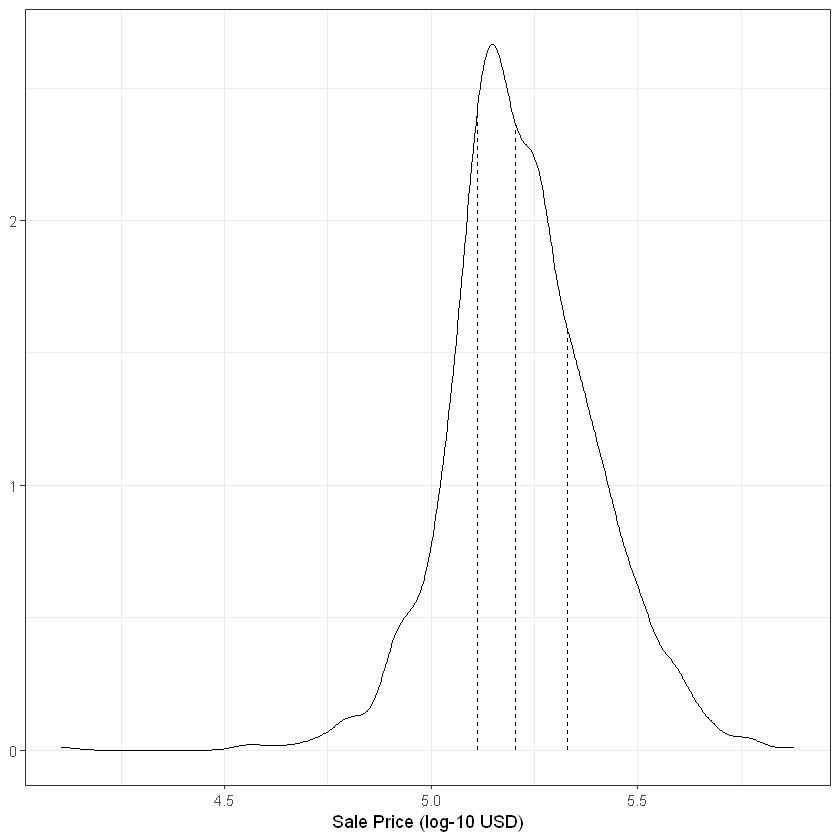

In [43]:
(quart_plot <-
    ggplot(ames, aes(x = Sale_Price)) +
    geom_line(stat = "density") +
    geom_segment(data = quantiles,
                 aes(x = value, xend = value, y = 0, yend = y),
                 lty = 2) +
    labs(x = "Sale Price (log-10 USD)", y = NULL))

In [44]:
set.seed(501)
ames_split <- initial_split(ames, prop = 0.8, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test <- testing(ames_split)
ames_train %>% dim ; ames_test %>% dim

[1] 2342   74

[1] 588  74

<br>

## 02.04. 검증 세트
- 신경망 초기에 연구자들은 훈련 세트 샘플을 다시 예측하여 성능을 측정하면 지나치게 낙관적인 결과가 나오며, 이로 인해 모델이 과적합

    **즉, 훈련 세트에서는 매우 잘 수행되었지만 테스트 세트에서는 성능이 좋지 않음**
    
- 이 문제를 해결하기 위해 작은 검증 데이터 세트를 보류하고 훈련될 때 성능을 측정하는 데 사용
- 검증 세트 오류율이 증가하기 시작하면 훈련이 중단

    **즉, 검증 세트는 테스트 세트 이전에 모델이 얼마나 잘 수행되었는지 대략적으로 파악하는 수단**
- 검증 세트가 훈련 세트의 하위 세트인지 아니면 데이터의 초기 분할에서 세 번째 할당인지는 분석 유형에 따라 결정

<br>

#### `initial_validation_split()`

- 데이터의 60%를 훈련, 20%를 검증, 20% 테스트 데이터로 할당

In [45]:
set.seed(52)
ames_val_split <- initial_validation_split(ames, prop = c(0.6, 0.2))
ames_val_split

<Training/Validation/Testing/Total>
<1758/586/586/2930>

In [46]:
ames_train <- training(ames_val_split)
ames_test <- testing(ames_val_split)
ames_val <- validation(ames_val_split)

<br>

## 02.05. 데이터 비용에 대한 고려사항
1. **모든 모델 구축 활동에서 테스트 세트를 격리하는 것이 중요**
2. **훈련 세트를 서브샘플링하는 기술은 특정 문제(예: 클래스 불균형)를 완화**
- 의도적으로 훈련 세트 데이터가 데이터가 추출된 모집단에서 벗어나게 만드는 유효하고 일반적인 기술
- 테스트 세트가 모델이 실제로 직면하게 될 내용을 계속해서 반영하는 것이 중요
- 즉, 테스트 세트는 모델에 제공될 새로운 데이터와 항상 유사해야 함